# Importações

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [36]:
import os
import pickle
models_prefix = './models-persisted'

def persist_instance(variable:any, file_name:str):
    if not os.path.exists(models_prefix): os.makedirs(models_prefix)

    with open(f'{models_prefix}/{file_name}.pkl', 'wb') as file:
        pickle.dump(variable, file)

def load_instance(path:str):
    with open(f'{path}', 'rb') as file:
        return pickle.load(file)

# Leitura dos dados

In [37]:
from essayDataDiggestor import EssayDataDiggestor

data_path = '../data/collected_data'
data_diggestor = EssayDataDiggestor()

not_measured_by_sensor = ['PT100 3 [ºC]', 'PT100 4 [ºC]', 'Vel. do Ar [m/s]']
target_col = 'Umidade Produto [%]'

# Reading data from files
df_train = data_diggestor.get_labeled_essays(data_path)
df_real_time = data_diggestor.get_essays(data_path)

# Removing columns not measured by sensors
df_train = df_train.drop(columns=not_measured_by_sensor).reset_index(drop=True)
df_real_time = df_real_time.drop(columns=not_measured_by_sensor).reset_index(drop=True)

print('DataFrame de treinamento')
display(df_train.head())
print('\n\nDataFrame com dados em tempo real do ensaio')
display(df_real_time.head())

DataFrame de treinamento


,Time,PT100 1 [ºC],PT100 2 [ºC],Temp. TH 1 [ºC],Umidade 1 [%],Temp. TH 2 [ºC],Umidade 2 [%],Ensaio,Umidade Produto [%]
0,0.000,23.681101,23.626140,23.174812,57.704340,24.255182,73.746678,0,55.223333
1,899.564,27.150231,27.212689,24.787157,47.790284,28.432172,87.234795,0,48.006667
2,1798.938,26.887455,26.675792,26.097392,44.201039,26.974166,92.332055,0,41.003333
3,2700.298,26.897853,26.742584,27.033274,42.788991,26.882220,93.655657,0,7.083333
4,3601.595,43.864988,39.788933,27.676899,40.073266,36.175378,36.280460,0,2.283333




DataFrame com dados em tempo real do ensaio


,Time,PT100 1 [ºC],PT100 2 [ºC],Temp. TH 1 [ºC],Umidade 1 [%],Temp. TH 2 [ºC],Umidade 2 [%],Ensaio
0,0.000,23.681101,23.626140,23.174812,57.704340,24.255182,73.746678,0
1,3.253,23.681888,23.623464,22.944946,57.779871,24.288020,73.914167,0
2,6.655,23.675593,23.618114,23.158393,57.628810,24.333993,74.577554,0
3,9.884,23.666780,23.609773,23.164961,57.326689,24.383250,75.809093,0
4,13.184,23.649784,23.598442,22.987635,56.486007,24.376682,77.267243,0


# Normalização dos dados

In [38]:
from sklearn.preprocessing import StandardScaler

identifier_columns = ['Ensaio']
scaler = StandardScaler()
scaler.fit(df_train.drop(columns=target_col))

df_scaled = scaler.transform(df_train.drop(columns=target_col))
df_scaled = pd.DataFrame(df_scaled, columns=df_train.drop(columns=target_col).columns)

df_scaled = pd.concat([df_scaled, df_train[[target_col]]], axis=1).drop(columns=identifier_columns)

df_train_norm = df_scaled.copy()
df_train_norm.head()

,Time,PT100 1 [ºC],PT100 2 [ºC],Temp. TH 1 [ºC],Umidade 1 [%],Temp. TH 2 [ºC],Umidade 2 [%],Umidade Produto [%]
0,-1.414184,-1.073482,-1.118343,-1.179055,0.752352,-1.058263,0.003619,55.223333
1,-0.707457,-0.655458,-0.632846,-0.737353,-0.007215,-0.356589,0.488132,48.006667
2,-0.000880,-0.687122,-0.705524,-0.378413,-0.282206,-0.601513,0.671234,41.003333
3,0.707258,-0.685869,-0.696482,-0.122028,-0.390390,-0.616958,0.718780,7.083333
4,1.415346,1.358640,1.069553,0.054293,-0.598456,0.944158,-1.342225,2.283333


In [39]:
del(df_scaled)
df_scaled = scaler.transform(df_real_time)
df_scaled = pd.DataFrame(df_scaled, columns=df_real_time.columns).drop(columns=identifier_columns)

df_real_time_norm = df_scaled.copy()
df_real_time_norm.head()

,Time,PT100 1 [ºC],PT100 2 [ºC],Temp. TH 1 [ºC],Umidade 1 [%],Temp. TH 2 [ºC],Umidade 2 [%]
0,-1.414184,-1.073482,-1.118343,-1.179055,0.752352,-1.058263,0.003619
1,-1.411628,-1.073387,-1.118706,-1.242027,0.758139,-1.052747,0.009635
2,-1.408955,-1.074146,-1.119430,-1.183553,0.746565,-1.045024,0.033465
3,-1.406418,-1.075208,-1.120559,-1.181754,0.723418,-1.036749,0.077704
4,-1.403826,-1.077255,-1.122093,-1.230333,0.659009,-1.037853,0.130083


# Treinamento de modelos

### Importação de modelos

In [40]:
# Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import Lars
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import TheilSenRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import PoissonRegressor

# Support Vector Machine
from sklearn.svm import SVR
from sklearn.svm import NuSVR

# Nearest Neighbors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import RadiusNeighborsRegressor

# Gaussian Process Regression
from sklearn.gaussian_process import GaussianProcessRegressor

# Decision Trees
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import ExtraTreeRegressor

# Ensemble Methods
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

# Neural Network
from sklearn.neural_network import MLPRegressor

### Treinamento

In [41]:
from sklearn.model_selection import train_test_split

X = df_train_norm.drop(columns=[target_col]).reset_index(drop=True)
y = df_train_norm[target_col].reset_index(drop=True)

print(f'Utilizando {len(X)} amostras de treinamento')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)#, stratify=y)

Utilizando 85 amostras de treinamento


### Cross validation

In [42]:
from sklearn.model_selection import cross_val_score
from json import dumps

base_models = [
  LinearRegression(),
  Ridge(max_iter=1000),
  Lasso(max_iter=1000),
  Lars(),
  ElasticNet(max_iter=1000),
  BayesianRidge(),
  SGDRegressor(max_iter=1000),
  TheilSenRegressor(max_iter=1000),
  HuberRegressor(max_iter=1000),
  PoissonRegressor(max_iter=1000),
  SVR(max_iter=1000),
  NuSVR(max_iter=1000),
  KNeighborsRegressor(n_neighbors=5),
  RadiusNeighborsRegressor(radius=5),
  GaussianProcessRegressor(),
  DecisionTreeRegressor(),
  ExtraTreeRegressor(),
  BaggingRegressor(),
  AdaBoostRegressor(),
  ExtraTreesRegressor(),
  RandomForestRegressor(),
  GradientBoostingRegressor(),
  HistGradientBoostingRegressor(),
  MLPRegressor(hidden_layer_sizes=[20, 20, 20],
    activation='tanh',
    max_iter=10000),
]

best_score = 0
best_model = None

results = {}

cv = 17
for estimator in base_models:
  
  model = estimator
  model_name = model.__class__.__name__
  scores = cross_val_score(model, X_train, y_train, cv=cv)

  results[model_name] = f'{scores.mean():.3f} +/- {scores.std():.3f}'

  if scores.mean() > best_score:
    best_score = scores.mean()
    best_model = model

print(f'Best model: {best_model} - score: {best_score}')

Best model: Lasso() - score: 0.7705775262556189


In [43]:
sorted_scores = dict(sorted(results.items(), key=lambda item: item[1].split(' ')[0]))
with open('result-cross-validation.json', 'w') as outfile:
    outfile.write(dumps(sorted_scores))

### Modelos interessantes


    "HuberRegressor": "0.518 +/- 1.434",
    "Ridge": "0.647 +/- 0.841",
    "LinearRegression": "0.657 +/- 0.848",
    "BayesianRidge": "0.668 +/- 0.799",
    "TheilSenRegressor": "0.669 +/- 0.862",
    "Lars": "0.703 +/- 0.475",
    "SGDRegressor": "0.710 +/- 0.605",
    "Lasso": "0.771 +/- 0.317"

### Gridsearch nos modelos interessantes

#### Função auxiliar

In [44]:
import matplotlib.pyplot as plt

def plot_essay_predictions():
    plt.figure(figsize=(8,8))
    plt.title("Model's predicted humidity")
    essays = list(df_real_time['Ensaio'].unique())
    for essay in essays:
        df_case = df_real_time[df_real_time['Ensaio'] == essay]
        df_case_scaled = scaler.transform(df_case)
        df_case_norm = pd.DataFrame(df_case_scaled, columns=df_case.columns)
        y_pred = clf.predict(df_case_norm.drop(columns=['Ensaio']))
        plt.scatter(df_case['Time'], y_pred, label =f'Ensaio {essay}')

    plt.xlabel('Process time (s)')
    plt.ylabel('Humidy (%)')
    plt.legend()
    plt.tight_layout()
    plt.show()

#### Huber Regressor

In [45]:
from sklearn.linear_model import HuberRegressor
HuberRegressor().get_params()

{'alpha': 0.0001,
 'epsilon': 1.35,
 'fit_intercept': True,
 'max_iter': 100,
 'tol': 1e-05,
 'warm_start': False}

Best estimator: HuberRegressor(alpha=0.001, max_iter=1000, tol=1e-06, warm_start=True)
Score: 51.86%


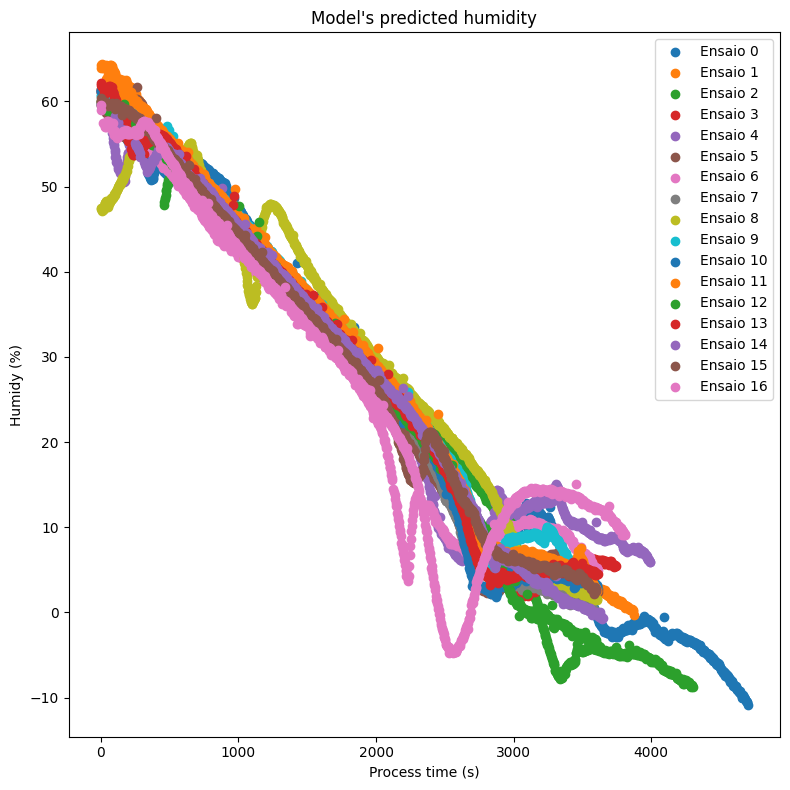

In [46]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import HuberRegressor

base_estimator = HuberRegressor(max_iter=1000)
param_grid = {
    'alpha': [0.00001, 0.0001, 0.001],
    'fit_intercept': [True, False],
    'tol': [1e-06, 1e-05, 1e-04],
    'warm_start': [True, False]
}

clf = RandomizedSearchCV(base_estimator, param_grid, cv=cv)
clf.fit(X_train, y_train)

print(f'Best estimator: {clf.best_estimator_}\nScore: {clf.best_score_*100:.2f}%')
plot_essay_predictions()

#### Ridge

In [47]:
from sklearn.linear_model import Ridge
Ridge().get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'positive': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.0001}

Best estimator: Ridge(alpha=0.1, max_iter=1000, random_state=1, tol=0.001)
Score: 66.72%


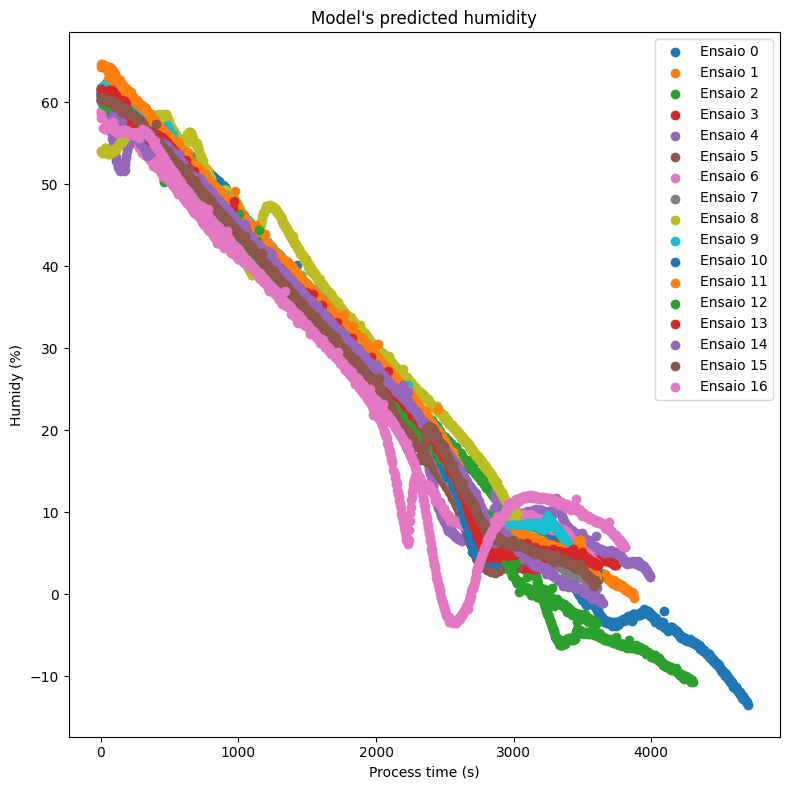

In [48]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Ridge

base_estimator = Ridge(max_iter=1000, random_state=1)
param_grid = {
    'alpha': [0.1, 1.0, 10],
    'copy_X': [True, False],
    'fit_intercept': [True, False],
    'positive': [True, False],
    'tol': [0.00001, 0.0001, 0.001]
}

clf = RandomizedSearchCV(base_estimator, param_grid, cv=cv)
clf.fit(X_train, y_train)

print(f'Best estimator: {clf.best_estimator_}\nScore: {clf.best_score_*100:.2f}%')
plot_essay_predictions()

#### Linear Regression

In [49]:
from sklearn.linear_model import LinearRegression
LinearRegression().get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}

Best estimator: LinearRegression(n_jobs=2)
Score: 65.66%


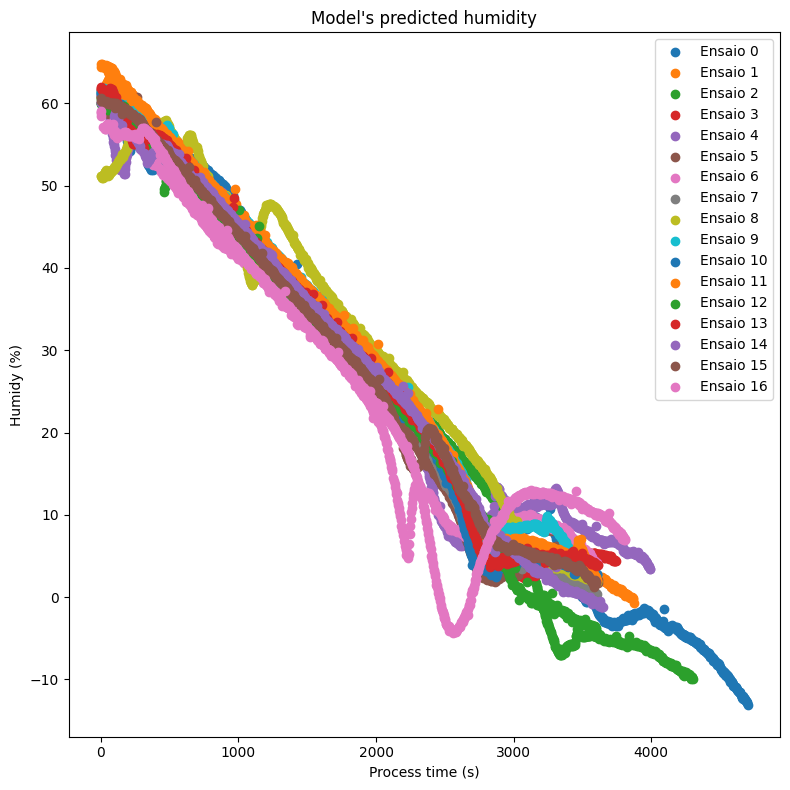

In [51]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression

base_estimator = LinearRegression()
param_grid = {
    'copy_X': [True, False],
    'fit_intercept': [True, False],
    'n_jobs': [None, 2, True],
    'positive': [True, False]
}

clf = RandomizedSearchCV(base_estimator, param_grid, cv=cv)
clf.fit(X_train, y_train)

print(f'Best estimator: {clf.best_estimator_}\nScore: {clf.best_score_*100:.2f}%')
plot_essay_predictions()